In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')

sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    "/storage/vbutoi/scratch/ESE/training/08_07_24_OCTA_FULLRES_CrossEntropy",
    "/storage/vbutoi/scratch/ESE/training/08_07_24_OCTA_FULLRES_CrossEntropy_wSVLS", # SVLS Models Seed 40
    "/storage/vbutoi/scratch/ESE/training/08_07_24_OCTA_FULLRES_SoftDice",
    "/storage/vbutoi/scratch/ESE/training/08_07_24_OCTA_FULLRES_SoftDice_wSVLS", # SVLS Models Seed 40
    "/storage/vbutoi/scratch/ESE/training/08_07_24_OCTA_FULLRES_AreaEstErr",
    "/storage/vbutoi/scratch/ESE/training/08_07_24_OCTA_FULLRES_AreaEstErr_wSVLS", # SVLS Models Seed 40
]

df_list = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list.append(df)
    except Exception as e:
        print(e)
df = pd.concat(df_list)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
for ikey in df.keys():
    print(ikey)

phase
epoch
loss
dice_score
ece_loss
edge_ece_loss
data
in_channels
iters_per_epoch
label
label_threshold
out_channels
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
loss_func
batch_reduction
from_logits
model
convs_per_block
filters
optim
lr
weight_decay
epochs
eval_freq
path
train


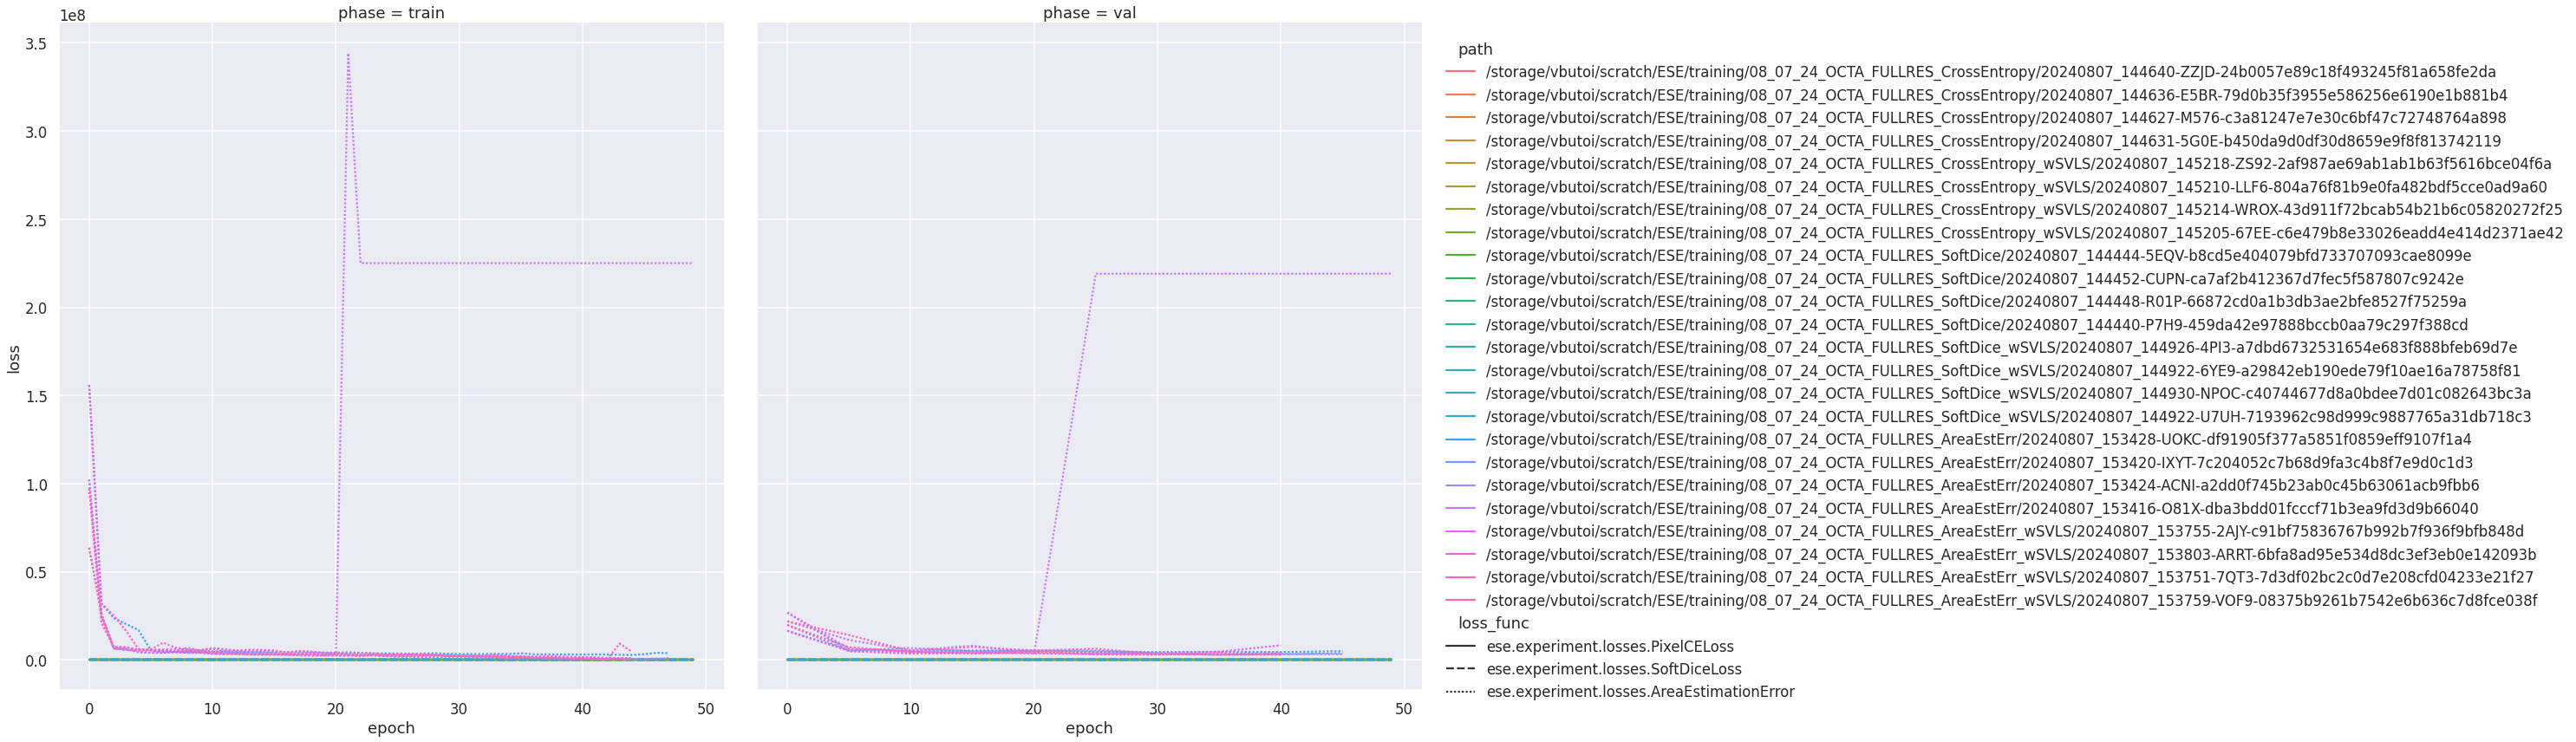

In [4]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='path',
    style='loss_func',   
    col='phase',
    kind='line',
    height=12,
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

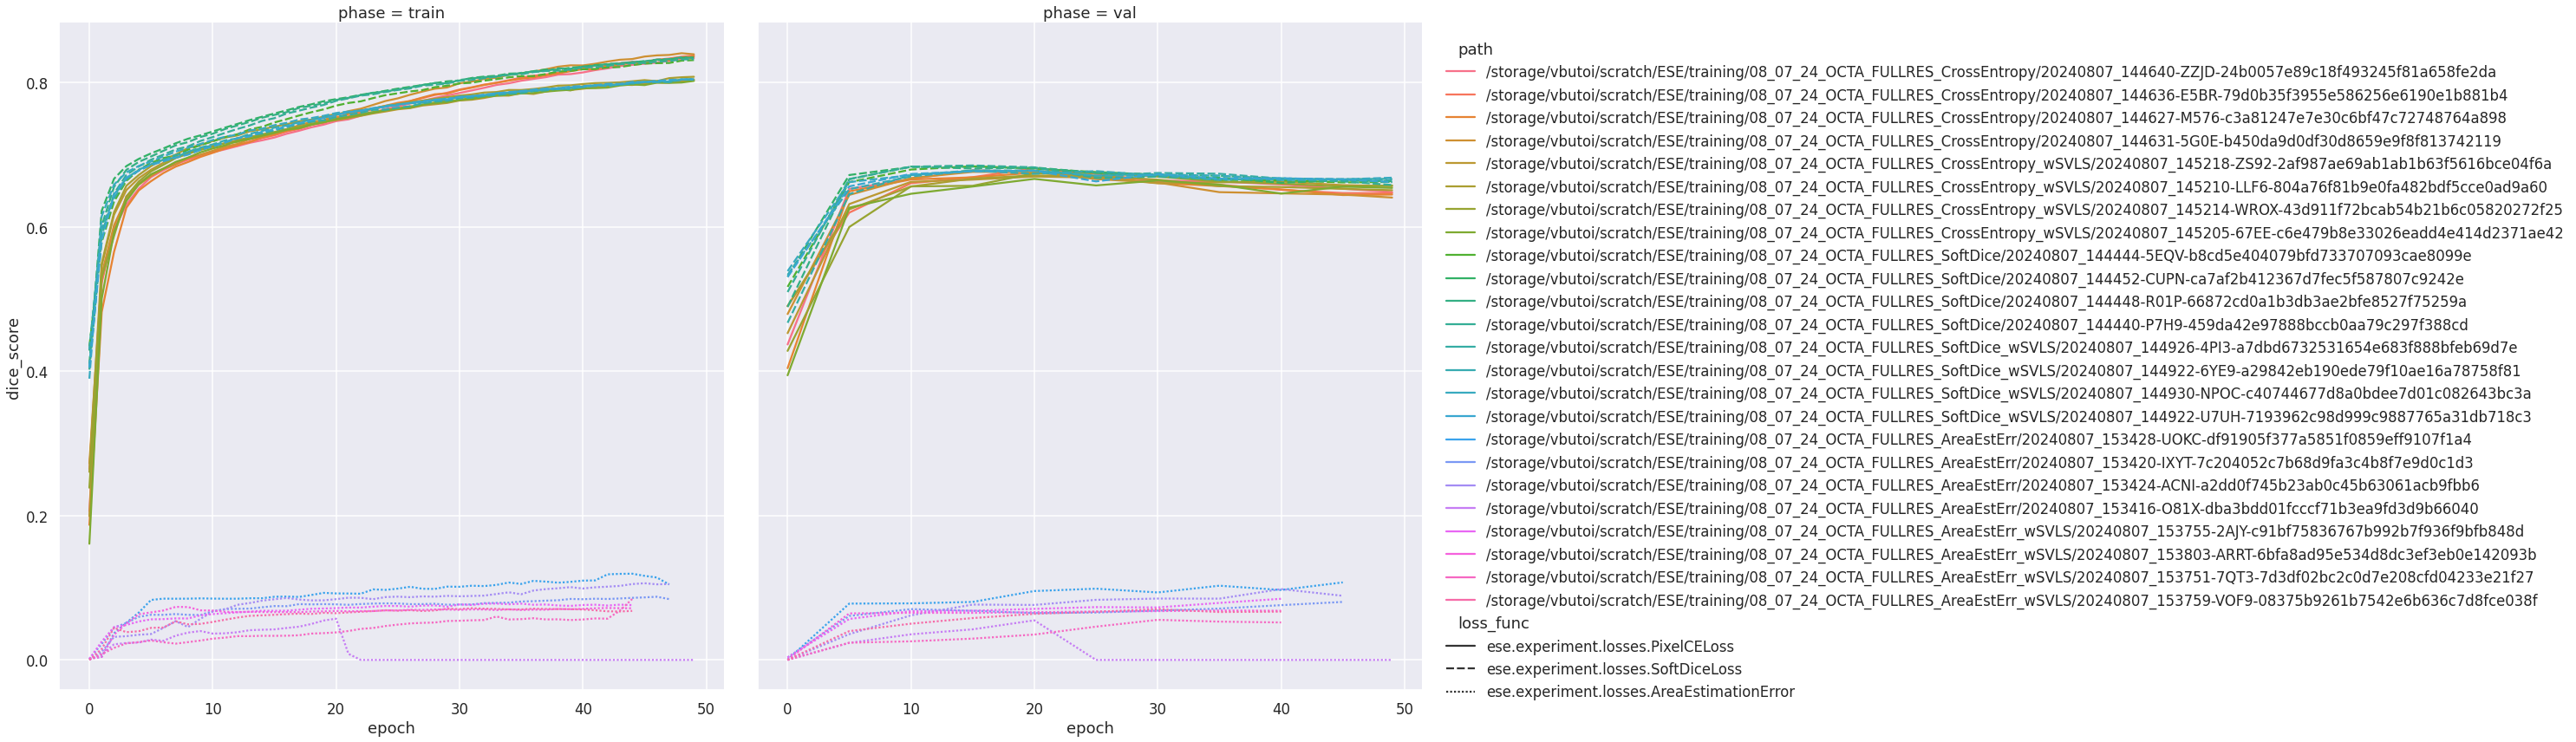

In [5]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='dice_score',
    hue='path',
    style='loss_func',   
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))